# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random
from IPython.display import display, clear_output
import bayes_opt

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from UTILITY_plotNMM import plotNMM, slicePlotNMM
from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam
from UTILITY_setLattice import setLattice

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

# Plot single particle twiss

In [3]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [4]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

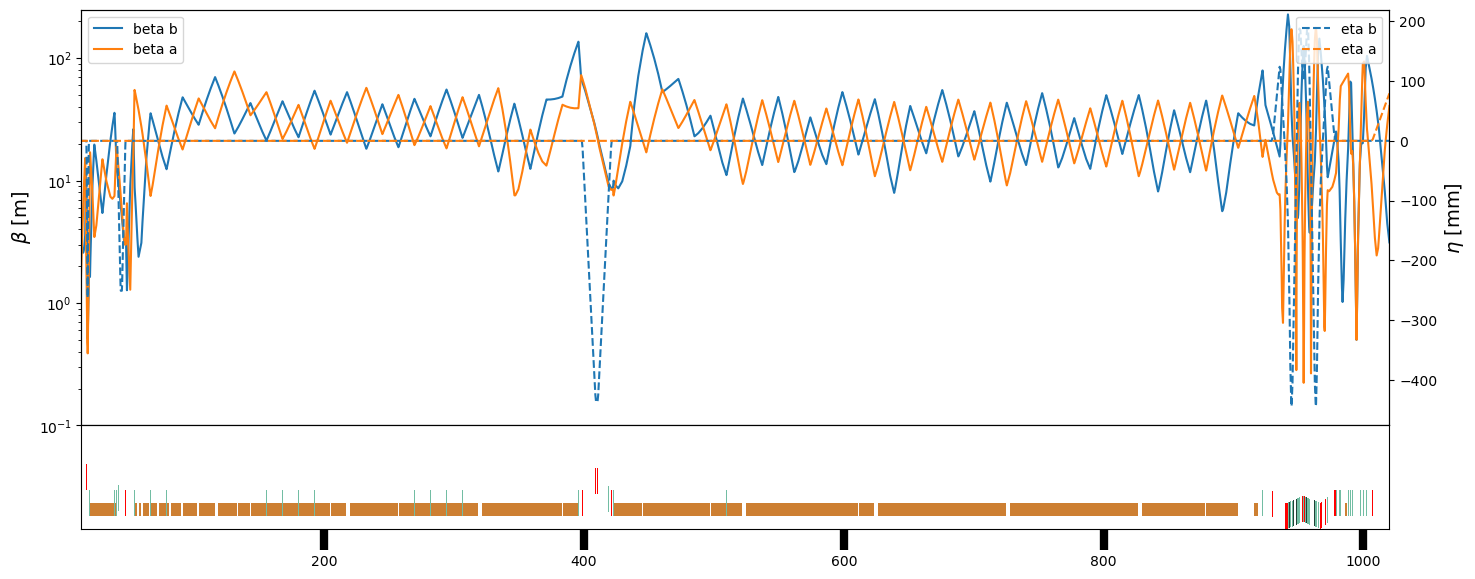

In [5]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

In [6]:
lastTrackedElement = "end"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')
#Can see present track_start and track_end values with `show beam`


#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [7]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly.h5'


modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 10000
)

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

#Set lattice to my latest default config
setLattice(tao)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [8]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

sigmaX = PPENT.std("x")
sigmaY = PPENT.std("y")
sigmaZ = PPENT.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")

0.00023143772341615218, 2.683760615145985e-05, 2.222710829003766e-05


# Bayesian optimization

## Optimizer functions

In [9]:
def phaseAndEnergyOptimization(
    self,
    **kwargs
):
    

    badValue = -1 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue

    try:
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue

    PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

    sigmaX = PPENT.std("x")
    sigmaY = PPENT.std("y")
    sigmaZ = PPENT.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z


    maximizeMe = 1 / (sigmaX * sigmaY * sigmaZ)
 
    
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series(
        
        kwargs | { #The pipe joins dictionaries 
        #"L1PhaseSet": L1PhaseSet,
        #"L2PhaseSet": L2PhaseSet,
        #"L2EnergyOffset": L2EnergyOffset,
        #"L3EnergyOffset": L3EnergyOffset,
        "sigmaX": sigmaX,
        "sigmaY": sigmaY,
        "sigmaZ": sigmaZ,
        "maximizeMe": maximizeMe
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    })

    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()
    
    return maximizeMe

"""
def optimizerWrapper( self, L1PhaseSet, L2PhaseSet, **kwargs ):
    return phaseAndEnergyOptimization(
        self,
        **{"L1PhaseSet": L1PhaseSet, "L2PhaseSet": L2PhaseSet}
    )
"""

"""
def optimizerWrapper( self, L1PhaseSet, L2PhaseSet, L2EnergyOffset, L3EnergyOffset, **kwargs):
    return phaseAndEnergyOptimization(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            "L2EnergyOffset": L2EnergyOffset,
            "L3EnergyOffset": L3EnergyOffset,
        }
    )
"""

"""
def optimizerWrapper( self, L1PhaseSet, L2PhaseSet, Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG, **kwargs ):
    return phaseAndEnergyOptimization(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "Q2FFkG": Q2FFkG,
            "Q1FFkG": Q1FFkG,
            "Q0FFkG": Q0FFkG,
            "Q0DkG": Q0DkG,
            "Q1DkG": Q1DkG,
            "Q2DkG": Q2DkG,
        }
    )
"""

def optimizerWrapper( self, L1PhaseSet, L2PhaseSet, Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, **kwargs ):
    return phaseAndEnergyOptimization(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "Q2FFkG": Q2FFkG,
            "Q1FFkG": Q1FFkG,
            "Q0FFkG": Q0FFkG,
        }
    )

## Do optimization

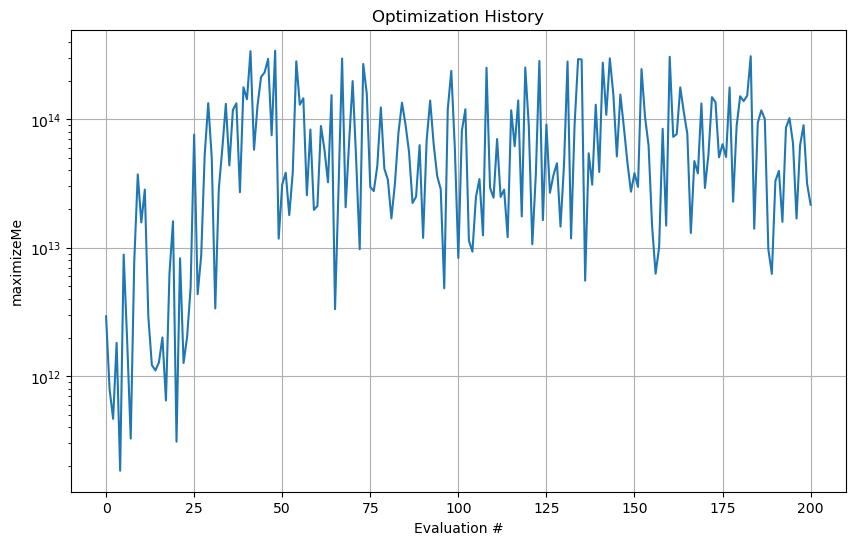

| 201       | 2.163e+13 | -34.75    | -50.84    | 117.6     | -229.6    | 142.3     | 81.05     | -92.44    | -69.79    |
    L1PhaseSet  L2PhaseSet     Q5FFkG     Q4FFkG      Q3FFkG      Q2FFkG  \
0   -30.768061  -53.533328 -62.851246 -92.805665   90.416991  125.859126   
0   -26.982842  -52.104544 -60.432001 -91.936281  112.100362  112.535388   
0   -29.947631  -53.326547 -66.987112 -97.543360   87.406476  122.247945   
0   -32.709390  -52.236930 -59.903995 -78.923709  112.711680  139.755030   
0   -25.030068  -42.610893 -67.056323 -70.370640   88.461513  144.241840   
..         ...         ...        ...        ...         ...         ...   
0   -27.359099  -43.095718 -62.801306 -94.235821   80.423371  146.294090   
0   -26.694227  -40.569978 -69.343999 -95.143901   80.203778  137.026460   
0   -24.614908  -38.159709 -62.398766 -94.113349   82.779390  142.449629   
0   -27.058264  -37.659067 -67.109833 -98.096803   82.128442  134.690849   
0   -34.754551  -50.844411 -69.789827 -92.

In [10]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()

    def updatePlot(self):
        plotKey = "maximizeMe"
        
        # Clear the previous figure to prevent flickering
        clear_output(wait=True)
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        #plt.plot(self.history.index, self.history['finalEmit'], '-o', markersize=8)
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        # Show plot
        plt.show()


# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()



def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
    
# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    #'L1PhaseSet': (-30, 10),
    #'L2PhaseSet': (-60, 10),
    'L1PhaseSet': makeBoundsTuple(0.2, -30),
    'L2PhaseSet': makeBoundsTuple(0.2, -45),
    #'L2EnergyOffset': (-200e6, 200e6),
    #'L3EnergyOffset': (-200e6, 200e6),
    
    #Full SCP ranges
    #'Q5FFkG': (-256, 0), 
    #'Q4FFkG': (-446, 0), 
    #'Q3FFkG': (0, 457),
    #'Q2FFkG': (0, 167),
    #'Q1FFkG': (-257, 0),
    #'Q0FFkG': (0, 167),
    #'Q0DkG': (-239, 0),
    #'Q1DkG': (0, 386),
    #'Q2DkG': (-223, 0),

    'Q5FFkG': makeBoundsTuple(0.2, -66), 
    'Q4FFkG': makeBoundsTuple(0.2, -83),
    'Q3FFkG': makeBoundsTuple(0.2, 97),
    'Q2FFkG': makeBoundsTuple(0.2, 130),
    'Q1FFkG': makeBoundsTuple(0.2, -223),
    'Q0FFkG': makeBoundsTuple(0.2, 110),
}

optimizer = bayes_opt.BayesianOptimization(
    f=problem.optimizerWrapper,
    pbounds=pbounds,
    random_state=2,
    allow_duplicate_points=True #2024-04-26 it was whining about this 
)

#Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
#and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
boInitialKappa = 10.
boFinalKappa = 0.1
boNumIter = 200
boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
                                   kappa=boInitialKappa,         #Default 2.576
                                   xi=0.0,              #Default 0
                                   kappa_decay=boKappaDecay,       #Default 0
                                   kappa_decay_delay=0  #Default 0                     
                                          )


optimizer.maximize(
    init_points=0, #Initial, random points
    n_iter=boNumIter,
    acquisition_function=acquisition_function
)


#print(res)
print(problem.history) 

## Check out results

In [11]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
problem.history.to_csv('output_data.csv', index=False)

bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

#Using triple quotes lets us use " inside the f-string
print(f"""\n{1e6*bestConfigData["sigmaX"]}, {1e6*bestConfigData["sigmaY"]}, {1e6*bestConfigData["sigmaZ"]}""")


setLattice(tao, **bestConfigDict)



tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))



L1PhaseSet   -2.776287e+01
L2PhaseSet   -4.060973e+01
Q5FFkG       -6.873049e+01
Q4FFkG       -9.719859e+01
Q3FFkG        7.920100e+01
Q2FFkG        1.396909e+02
Q1FFkG       -2.338263e+02
Q0FFkG        1.284733e+02
sigmaX        2.584124e-05
sigmaY        1.024798e-05
sigmaZ        1.104166e-05
maximizeMe    3.419901e+14
Name: 0, dtype: float64

25.841244235923522, 10.24798497802944, 11.04166466490006


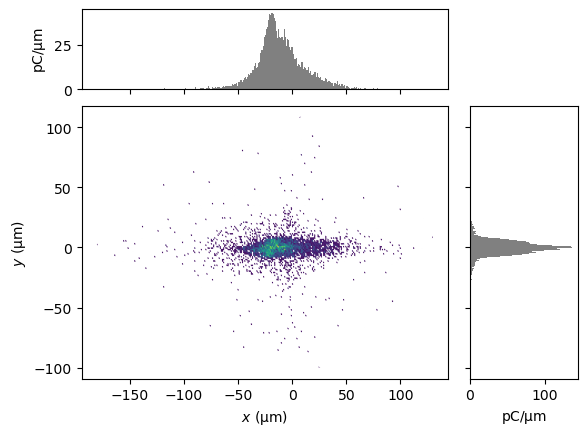

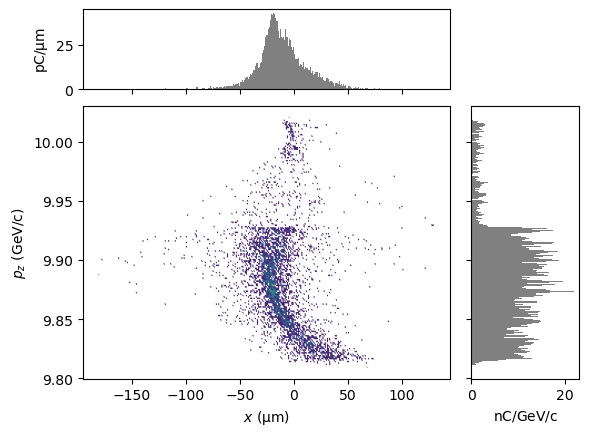

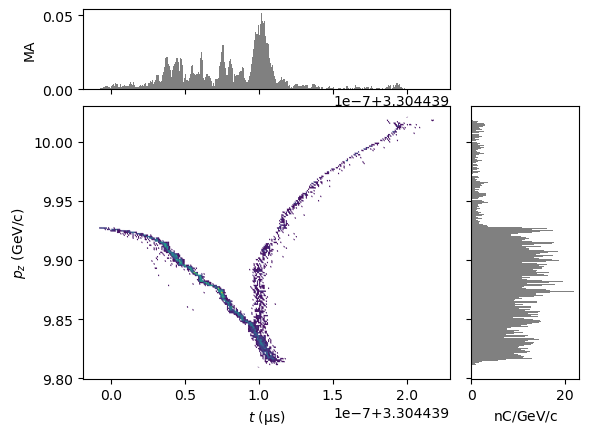

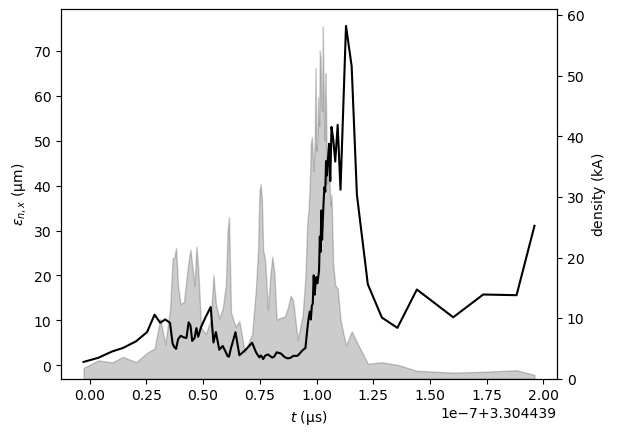

In [12]:
display(plotNMM(PPENT, 'x', 'y',  bins=300))
display(plotNMM(PPENT, 'x', 'pz', bins=300))
display(plotNMM(PPENT, 't', 'pz', bins=300))
display(slicePlotNMM(PPENT, 'norm_emit_x',n_slice=100))